In [1]:
%matplotlib notebook
import sys
sys.path.append('/home/christian/repos/tempo-py')
sys.path.append('/home/christian/repos/non_equilibrium/Tempo')

Below the main setup is done for the Tempo calculation. It is based on the code newmpo.py in the repository. It loads all the files from the repesitory so if their names are changed they cannot be found!

In [2]:
import newquaPyVec as qp
from newquaPyVec import itab, freeprop
import MpsMpo_site_level_operations as slo
import MpsMpo_block_level_operations as blo
from MpsMpo_block_level_operations import mps_block, mpo_block
from MpsMpo_site_level_operations import mps_site, mpo_site
import Ch_lineshapes as ln
import numpy as np
import pickle
import time
from qutip import create
from numpy import linalg, zeros
import matplotlib.pyplot as plt

from math import fmod
from tensor_algebra import *
import os.path

def datload(filename):
    #function to unpickle data files and output them as a list
    f=open(filename, "rb")
    dlst=pickle.load(f,encoding='bytes')

    while 1:
        try:
            dlst.append(pickle.load(f))
        except (EOFError):
            break
    
    f.close()
    return dlst

def sitetensor(eigl,dk,dkm,k,n,ham,dt):
    #constructs the rank-4 tensors sites that make up the network
    
    #initialise rank-4 tensor of zeros
    l=len(eigl)
    tab=zeros((l**2,l**2,l**2,l**2),dtype=complex)
    
    #construct the bare rank-2 influence functional factor
    if dk==1:
        iffactor=itab(eigl,1,k,n,dkm)*qp.itab(eigl,0,k,n,dkm)*freeprop(ham,dt)
    else:
        iffactor=qp.itab(eigl,dk,k,n,dkm)
    
    #loop through setting the non-zero elements of the rank-4 output tensor
    for i1 in range(l**2):
        for a1 in range(l**2):
            tab[i1][i1][a1][a1]=iffactor[i1][a1]    
    
    #if this is to be a site at the end of an mpo chain we  first sum over the east index
    #and replace with a dummy east index with dim=1
    if dk==dkm:
        return np.expand_dims(np.einsum('ijkl->ijk',tab),-1)
    else:        
        return tab

def tempo_mpoblock(eigl,ham,dt,dkm,k,n):
    #returns a TEMPO block of length dkm
    
    #initialise blank MPO block
    blk=mpo_block(0,0,0)
    #append dkm sites to the blank block
    for ii in range(1,dkm+1):
            blk.append_site(sitetensor(eigl,ii,dkm,k,n,ham,dt))
    return blk

def tempo(eigl,eta,irho,ham,dt,ntot,dkm,p,c=1,mod=0,datf=None,savemps=None):
    #implements state propogation using TEMPO
    #datf and savemps are the filenames for the data and mps to be stored to
    #c is the truncation method and labels elements of svds list below
    #p is the appropriate truncation paramater that goes with the method c

    #define rank-3 tensor by giving a delt dummy west index. this is used as the new end site
    #of the mps after each contraction with an mpo
    edge=np.expand_dims(np.eye(len(eigl)**2),1)
    
        
    #set some parameters and create table of makri coeffs qp.ctab from eta
    t0=time.time()
    svds=['fraction','accuracy','chi']
    l=len(eigl)
    precision=10**(-0.1*p)
    qp.trot=0
    qp.ctab=qp.mcoeffs(mod,eta,dkm,dt,ntot)
    
    #reshape initial matrix irho into vector rho and create data list
    rho=np.array(irho).reshape(l**2)
    datlis=[[0,rho]]
    
    #initialse blank MPS and create a single site from the initial state rho and the first 
    #influence functional factor I0
    mps=mps_block(0,0,0)
    mps.insert_site(0,np.expand_dims(np.expand_dims(rho*qp.itab(eigl,0,0,ntot,ntot)[0][:],-1),-1))
    jj0=1
    #initialise single site propagator mpo and termination propagator mpo 
    propmpo,termmpo=tempo_mpoblock(eigl,ham,dt,1,1,ntot),tempo_mpoblock(eigl,ham,dt,1,1,1)
    
    #set how regularly the mps is saved - only if also writing data to file
    if type(datf)==str and type(savemps)==int:
        smps=savemps
    else:
        smps=ntot+1
    
    if type(datf)==str:
        #check if data files and mps already exists
        if os.path.isfile(datf) and os.path.isfile('mps_'+datf):
            #extraxt mps and the timestep it is at
            mpsfile=open('mps_'+datf,"rb")
            mps=pickle.load(mpsfile)           
            jj0=pickle.load(mpsfile)
            mpsl=mps.N_sites
            #build correct sized mpos to resume propagation
            if jj0<=dkm:
                propmpo,termmpo=tempo_mpoblock(eigl,ham,dt,jj0,jj0,ntot),tempo_mpoblock(eigl,ham,dt,jj0,jj0,jj0)
            elif mod==1:
                propmpo,termmpo=tempo_mpoblock(eigl,ham,dt,mpsl,jj0,ntot),tempo_mpoblock(eigl,ham,dt,mpsl,jj0,jj0)
            else:
                propmpo,termmpo=tempo_mpoblock(eigl,ham,dt,mpsl,mpsl+1,ntot),tempo_mpoblock(eigl,ham,dt,mpsl,mpsl+1,mpsl+1)
            
            #import previous data
            datlis=datload(datf)
            #check we arent asking for data we already have
            if len(datlis)>=ntot:
                return print("data already collected up to ntot")
            #trim data back since there might already exist data for points beyond
            #where the last mps was saved
            datlis=datload(datf)[:jj0]
            #reopen previous data file and overwrite with trimmed data ready to append new data to
            datfile=open(datf,"wb")
            pickle.dump(datlis,datfile)
            print("resuming propagation")
         
        else:
            #if either data or mps files dont exist then start fresh data file
            datfile=open(datf,"wb")
            pickle.dump(datlis,datfile)

    
    #iteratively apply MPO's to the MPS and readout/store data
    for jj in range(jj0,ntot+1):
        #Printing which timestep is about to be computed
        #print("\npoint: "+str(jj)+" of "+str(ntot))
        ttt=time.time()
        
        #readout physical density matrix and append to data list/save to file
        dat=mps.readout(termmpo)
        datlis.append([jj*dt,dat])
        
        if type(datf)==str:
            if fmod(jj,smps)==0:
                mpsfile=open('mps_'+datf,"wb")
                pickle.dump(mps,mpsfile)
                pickle.dump(jj,mpsfile)
                mpsfile.close()  
                
            pickle.dump([jj*dt,dat],datfile)
            datfile.flush()
        
        #contract with propagation mpo and insert the new end site, growing the MPS by one site
        mps.contract_with_mpo(propmpo,prec=precision,trunc_mode=svds[c])
        mps.insert_site(0,edge)
        
        if jj<dkm:
            #this is the growth stage: termination and propagation mpos each have their end sites
            #updated with new makri coefficients and then a new site appended
            termmpo.data[jj-1].update_site(tens_in=sitetensor(eigl,jj,jj+1,jj+1,jj+1,ham,dt))
            termmpo.append_site(sitetensor(eigl,jj+1,jj+1,jj+1,jj+1,ham,dt))
            propmpo.data[jj-1].update_site(tens_in=sitetensor(eigl,jj,jj+1,jj+1,ntot,ham,dt))
            propmpo.append_site(sitetensor(eigl,jj+1,jj+1,jj+1,ntot,ham,dt))
        elif mod==1:
            #beyond the growth stage and if we are using newquapi coefficients we
            #update the end (dkm'th) site each timestep with modified coefficients
            #but dont append a new site. Finally contract away the now unused end site of the mps
            #(opposite side to the side the new tensor "edge" is attached to above)         
            termmpo.data[dkm-1].update_site(tens_in=sitetensor(eigl,dkm,dkm,jj+1,jj+1,ham,dt))
            propmpo.data[dkm-1].update_site(tens_in=sitetensor(eigl,dkm,dkm,jj+1,ntot,ham,dt))
            mps.contract_end()
        elif jj==dkm:
            #if not using newquapi coefficients then only need to update end sites once at the dkm'th timestep
            termmpo.data[dkm-1].update_site(tens_in=sitetensor(eigl,dkm,dkm,dkm+1,dkm+1,ham,dt))
            propmpo.data[dkm-1].update_site(tens_in=sitetensor(eigl,dkm,dkm,dkm+1,ntot,ham,dt))
            mps.contract_end()         
        else:
            #for jj>dkm without newquapi the propagation and termination are identical at every step so 
            #we only need to contract the end mps site
            mps.contract_end()   
        
        #Print how the MPS looks after the computation and the time used
        print("bond dims: "+str(mps.bonddims())+" total size: "+str(mps.totsize()))
        print("time: "+str(time.time()-ttt)+" prec: "+str(precision)+" length: "+str(mps.N_sites))
        
    print('total time: {0:.3f} sec'.format(time.time()-t0))    
    if type(datf)==str: 
        datfile.close()
    return datlis 

This function takes a target operator (A) and writes it in the eigenbasis of B.

In [3]:
def BasisCh(A, B):
    #writes A in the eigenbasis of B
    #obviously both must be of the same dimension
    
    #eigenbasis for B where elements with an absolute 
    #value below 10^(-threshold) are set to zero
    threshold = 1e-10
    BE,BV = linalg.eigh(B)
    BV[np.absolute(BV)<threshold]=0+1j*0 
    BE[np.absolute(BE)<threshold]=0
    
    #dimension of system Hilbert space
    dim = len(BE)

    #write H0 in interaction operators eigenvector basis
    a = np.zeros([dim,dim]) + 1j*np.zeros([dim,dim]) 
    for i in range(dim):
        for j in range(dim):
            a[i][j] = np.dot(np.conj(BV[:,i]),np.dot(A,BV[:,j]))
    a[np.absolute(a)<threshold] = 0+1j*0
    
    if np.array_equal(A,B):
        if np.allclose(np.real(a.diagonal()),BE,threshold):
            return a
        else:
            print('interaction operator was not diagonalised properly')
    else: 
        return a

This part is for describing the specific system Hamiltonian and interaction that is considered. In the present computation we are considering the "free" Caldeira-Leggett model with   
$H_s=\omega a^\dagger a$  
$H_I=(a^\dagger+a)\sum_\alpha B_\alpha$  
$H_E=\sum_\alpha \epsilon_\alpha b_\alpha^\dagger b_\alpha$

In [4]:
DIM = 3
ad= np.array(create(DIM).full())
a=ad.transpose()
#interaction operator
si = ad+a
Si = BasisCh(si,si)
eigs = np.real(Si.diagonal())

#system energy operator
omega = 1
h0 = omega*np.dot(ad,a)
H0 = BasisCh(h0,si)

#Initial density matrix with one excitation
Rhoi=np.zeros([DIM,DIM])
Rhoi[1][1]=1
rhoi = BasisCh(Rhoi,si)

#Initial density matrix with zero excitations
Rhoi0=np.zeros([DIM,DIM])
Rhoi0[0][0]=1
rhoi0 = BasisCh(Rhoi0,si)


#occupation operator
pocc = np.dot(ad,a)
Pocc = BasisCh(pocc,si)

In this computation we are considering the ohmic spectral density $J(\omega)=A \omega e^{-\omega/\omega_c}$. We considering two different coupling strengths, $A_{weak}$ and $A_{stronger}$

Firstly we will find proper convergence parameters for the weak coupling case. To obtain convergence the three main parameters are dkmax (related to memomry cutoff), dt (related to trotter expansion) and precision (related to MPS computation). To test for dt convergence one should run computations with the number of time steps being equal to dkmax. This means that there will be no memory cutoff! one can then keep the product of dkmax and dt constant and find out when dt is converged. For this one should initially start out with a sufficiently high precision. Once the dt threshold has been found one can increse nt and see how large dkmax has to be to acheive convergence. Lastly one should try lowering the precision until the threshold convergence value is found. This procedure should be iterated several times.  

In [5]:
CouplingRange = [1]
dkmaxRange1 = [5,10,15,20,30,40]
precisRange = [50]
for cc in CouplingRange:
    for kk in dkmaxRange1:
        for qq in precisRange:
            def etaTest(t):
                #Double integral over the correlation function <B(t-s)B(s)>.
                #The spectral density is A*w^s*e^(-w/wc) with additional 
                #possibility of spatial seperation between two systems (mu-parameter)
                #(time, Temperature, s, wc, mu, A)
                return ln.eta_all(t,0,1,4,0,0.04*cc)

            dkmax=kk
            Precision = qq

            delt=5/kk
            TimeSteps=kk
            name="ConvergenceTest_coup"+str(cc)+"_dkm"+str(dkmax)+"_dt"+str(delt)+"_Prec"+str(qq)+".pickle"
            daa=tempo(eigs,etaTest,rhoi,H0,delt,TimeSteps,dkmax,Precision,datf=name,savemps=4)

data already collected up to ntot
data already collected up to ntot
data already collected up to ntot
data already collected up to ntot
data already collected up to ntot
data already collected up to ntot


<IPython.core.display.Javascript object>


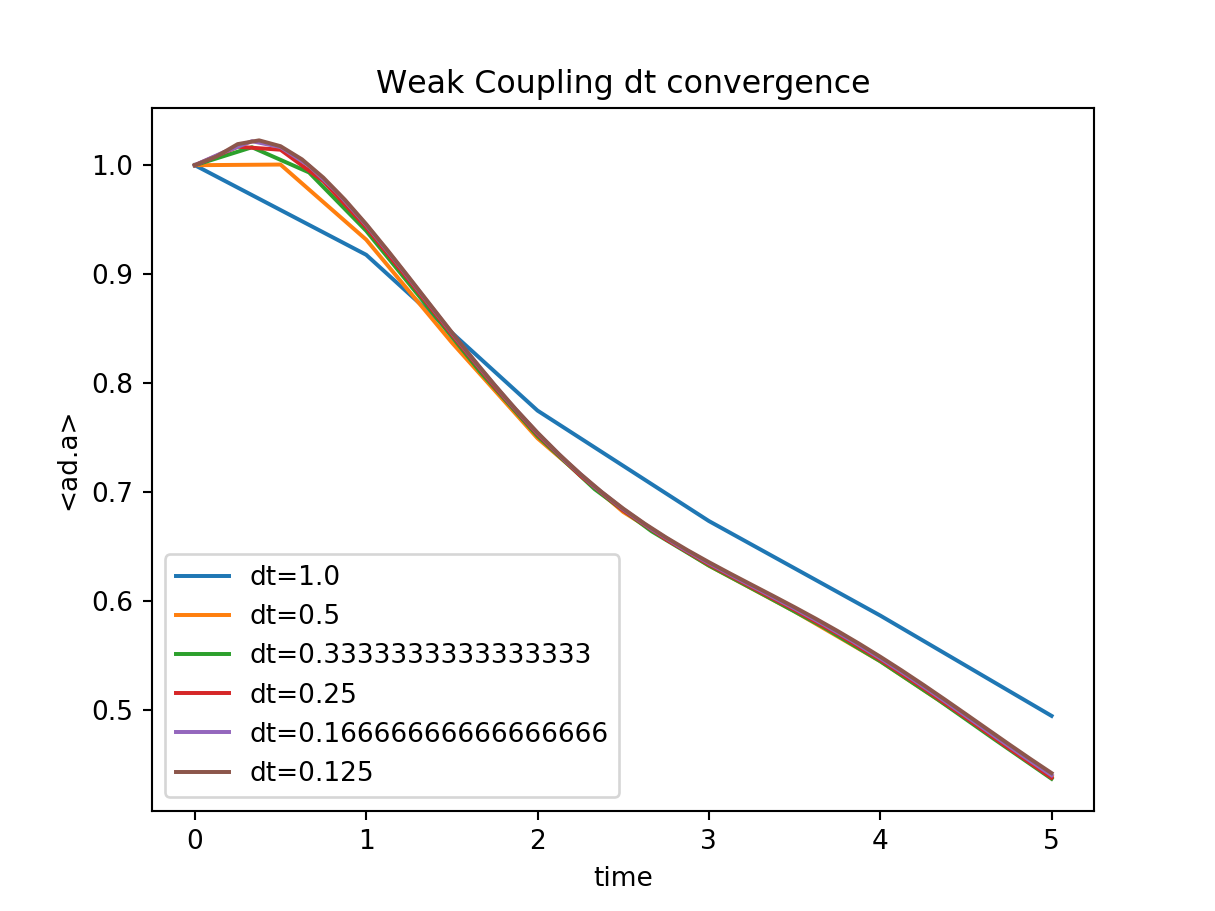

In [6]:
plt.figure(1)
for cc in CouplingRange:
    for kk in dkmaxRange1:
        for qq in precisRange:
            daataa = datload("ConvergenceTest_coup"+str(cc)+"_dkm"+str(kk)+"_dt"+str(5/kk)+"_Prec"+str(qq)+".pickle")
            TIME = [y[0] for y in daataa]
            steps = len(TIME)
            Occu = np.zeros([steps])
            for ii in range(steps):
                Occu[ii] = np.trace(np.dot(daataa[ii][1].reshape(DIM,DIM),Pocc)).real
            plt.plot(TIME,Occu,label='dt='+str(5/kk))
plt.ylabel('<ad.a>')
plt.xlabel('time')
plt.title('Weak Coupling dt convergence') 
plt.legend(loc='lower left')
plt.show()

This shows that for weak coupling a dt of around 1/6 should be sufficient. Next up we increase the of the computation such that it captures the dynamics of interest. Choose final time = 10. This means that $steps = 10/dt=6\cdot10=60$.

In [7]:
dkmaxRange2 = [5,10,15,20]
for cc in CouplingRange:
    for kk in dkmaxRange2:
        for qq in precisRange:
            def etaTest(t):
                #Double integral over the correlation function <B(t-s)B(s)>.
                #The spectral density is A*w^s*e^(-w/wc) with additional 
                #possibility of spatial seperation between two systems (mu-parameter)
                #(time, Temperature, s, wc, mu, A)
                return ln.eta_all(t,0,1,4,0,0.04*cc)

            dkmax=kk
            Precision = qq

            delt=0.16
            TimeSteps=60
            name="ConvergenceTestDkmax_coup"+str(cc)+"_dkm"+str(dkmax)+"_dt"+str(delt).replace(".","")+"_Prec"+str(qq)+".pickle"
            daa=tempo(eigs,etaTest,rhoi,H0,delt,TimeSteps,dkmax,Precision,datf=name,savemps=4)

data already collected up to ntot
data already collected up to ntot
data already collected up to ntot
data already collected up to ntot


<IPython.core.display.Javascript object>


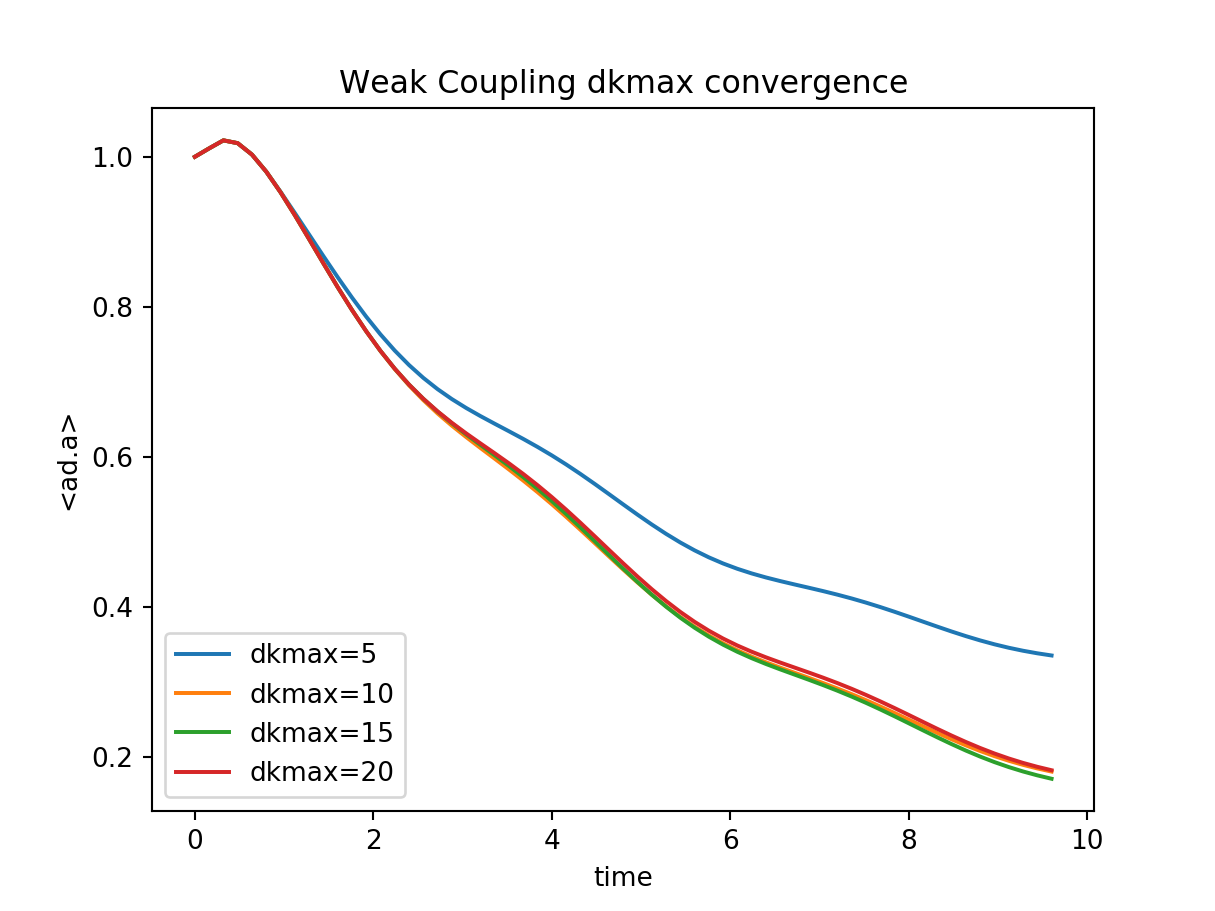

In [8]:
plt.figure(2)
for cc in CouplingRange:
    for kk in dkmaxRange2:
        for qq in precisRange:
            daataa = datload("ConvergenceTestDkmax_coup"+str(cc)+"_dkm"+str(kk)+"_dt"+str(0.16).replace(".","")+"_Prec"+str(qq)+".pickle")
            TIME = [y[0] for y in daataa]
            steps = len(TIME)
            Occu = np.zeros([steps])
            for ii in range(steps):
                Occu[ii] = np.trace(np.dot(daataa[ii][1].reshape(DIM,DIM),Pocc)).real
            plt.plot(TIME,Occu,label='dkmax='+str(kk))
plt.ylabel('<ad.a>')
plt.xlabel('time')
plt.title('Weak Coupling dkmax convergence') 
plt.legend(loc='lower left')
plt.show()

From this result $dkmax=10$ looks like a great choice (for some reason it is better convergced than $dkmax =15$ which is a bit weird).

What is left is to try lowering the precision and see if that is possible.

In [9]:
precisRange = [30, 40, 50]
for cc in [1]:
    for kk in [10]:
        for qq in precisRange:
            def etaTest(t):
                #Double integral over the correlation function <B(t-s)B(s)>.
                #The spectral density is A*w^s*e^(-w/wc) with additional 
                #possibility of spatial seperation between two systems (mu-parameter)
                #(time, Temperature, s, wc, mu, A)
                return ln.eta_all(t,0,1,4,0,0.04*cc)

            dkmax=kk
            Precision = qq

            delt=0.16
            TimeSteps=60
            name="ConvergenceTestPrec_coup"+str(cc)+"_dkm"+str(dkmax)+"_dt"+str(delt).replace(".","")+"_Prec"+str(qq)+".pickle"
            daa=tempo(eigs,etaTest,rhoi,H0,delt,TimeSteps,dkmax,Precision,datf=name,savemps=4)

data already collected up to ntot
data already collected up to ntot
data already collected up to ntot


<IPython.core.display.Javascript object>


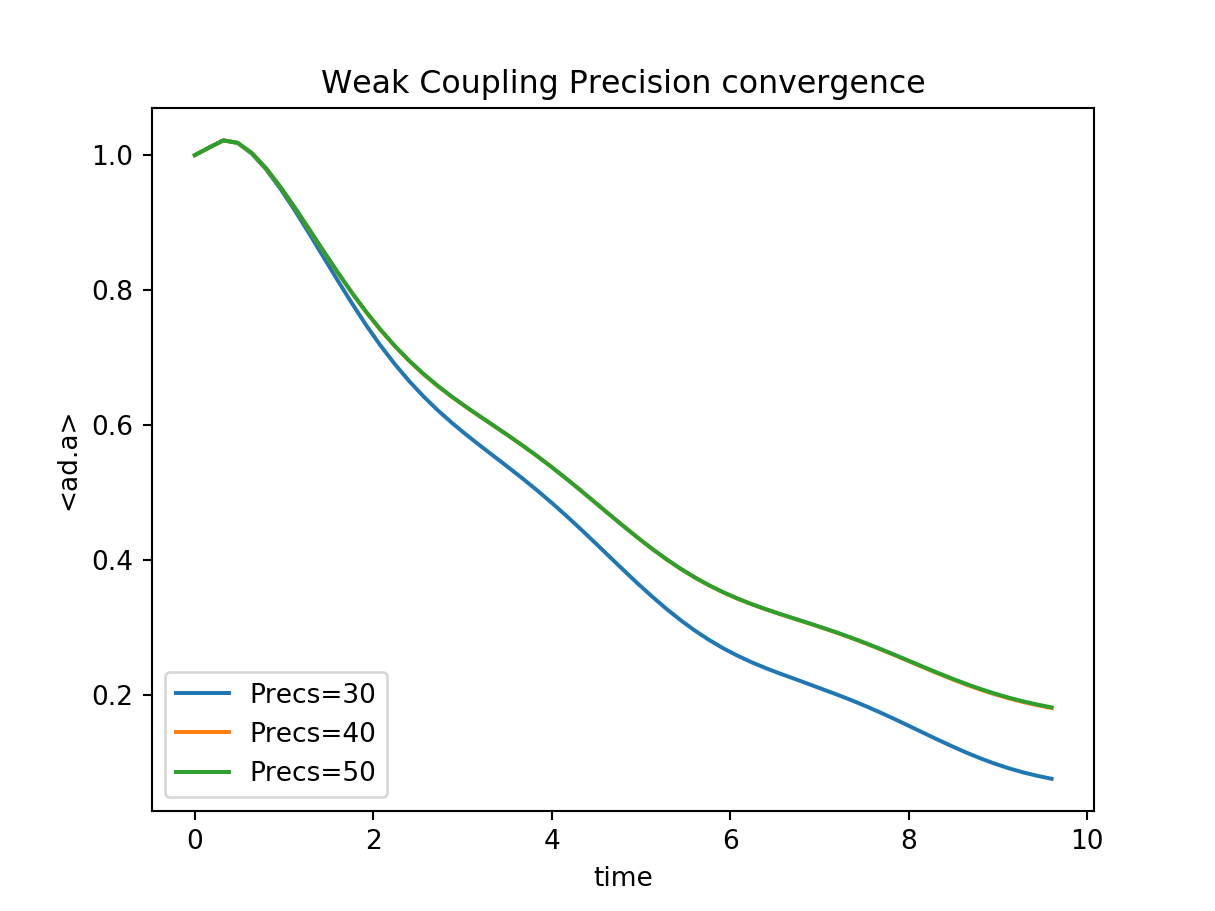

In [10]:
plt.figure(3)
for cc in [1]:
    for kk in [10]:
        for qq in precisRange:
            daataa = datload("ConvergenceTestPrec_coup"+str(cc)+"_dkm"+str(kk)+"_dt"+str(0.16).replace(".","")+"_Prec"+str(qq)+".pickle")
            TIME = [y[0] for y in daataa]
            steps = len(TIME)
            Occu = np.zeros([steps])
            for ii in range(steps):
                Occu[ii] = np.trace(np.dot(daataa[ii][1].reshape(DIM,DIM),Pocc)).real
            plt.plot(TIME,Occu,label='Precs='+str(qq))
plt.ylabel('<ad.a>')
plt.xlabel('time')
plt.title('Weak Coupling Precision convergence') 
plt.legend(loc='lower left')
plt.show()

Here the orange is almost exactly underneath the green curve, so a precision of 40 is sufficient to acheive convergence! Finally the entire procedure should be repeated to ensure truthfullness of results. However as we saw that the precision was initially sufficiently high we choose to assume the first run is sufficient....
Now we want to increase the coupling strength which could most likely affect the convergence parameters. So a similar procedure as before must be employed. However given the knowledge from the previous results some parameters can be excluded. 

In [11]:
dkmaxRange3 = [4,8,16,24,32]
for cc in [10]:
    for kk in dkmaxRange3:
        for qq in [60]:
            def etaTest(t):
                #Double integral over the correlation function <B(t-s)B(s)>.
                #The spectral density is A*w^s*e^(-w/wc) with additional 
                #possibility of spatial seperation between two systems (mu-parameter)
                #(time, Temperature, s, wc, mu, A)
                return ln.eta_all(t,0,1,4,0,0.04*cc)

            dkmax=kk
            Precision = qq

            delt=2/kk
            TimeSteps=kk
            name="ConvergenceTestdtStrong_coup"+str(cc)+"_dkm"+str(dkmax)+"_dt"+str(delt).replace(".","")[:3]+"_Prec"+str(qq)+".pickle"
            daa=tempo(eigs,etaTest,rhoi,H0,delt,TimeSteps,dkmax,Precision,datf=name,savemps=4)

data already collected up to ntot
data already collected up to ntot
data already collected up to ntot
data already collected up to ntot
data already collected up to ntot


<IPython.core.display.Javascript object>


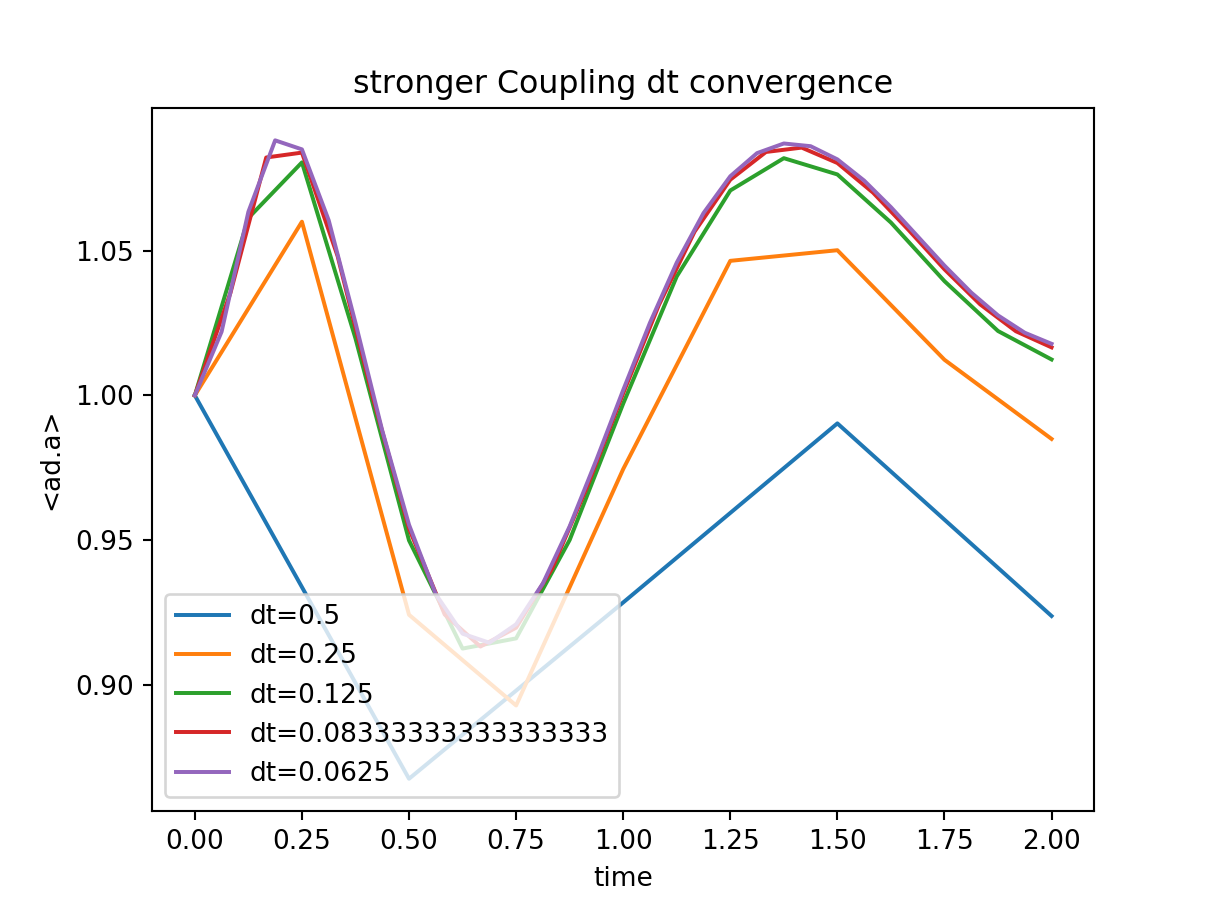

In [12]:
plt.figure(4)
for cc in [10]:
    for kk in dkmaxRange3:
        for qq in [60]:
            daataa = datload("ConvergenceTestdtStrong_coup"+str(cc)+"_dkm"+str(kk)+"_dt"+str(2/kk).replace(".","")[:3]+"_Prec"+str(qq)+".pickle")
            TIME = [y[0] for y in daataa]
            steps = len(TIME)
            Occu = np.zeros([steps])
            for ii in range(steps):
                Occu[ii] = np.trace(np.dot(daataa[ii][1].reshape(DIM,DIM),Pocc)).real
            plt.plot(TIME,Occu,label='dt='+str(2/kk))
plt.ylabel('<ad.a>')
plt.xlabel('time')
plt.title('stronger Coupling dt convergence') 
plt.legend(loc='lower left')
plt.show()

Here we already see that increaseing th coupling means that our convergence parameters change. $dt=1/8$ is almost sufficiet but only for shorter times. So we will use $dt=1/10$

In [13]:
for cc in [10]:
    for kk in [8,16,24,26,28]:
        for qq in [60]:
            def etaTest(t):
                #Double integral over the correlation function <B(t-s)B(s)>.
                #The spectral density is A*w^s*e^(-w/wc) with additional 
                #possibility of spatial seperation between two systems (mu-parameter)
                #(time, Temperature, s, wc, mu, A)
                return ln.eta_all(t,0,1,4,0,0.04*cc)

            dkmax=kk
            Precision = qq

            delt=0.1
            TimeSteps=100
            name="ConvergenceTestDkmax_coup"+str(cc)+"_dkm"+str(dkmax)+"_dt"+str(delt).replace(".","")+"_Prec"+str(qq)+".pickle"
            daa=tempo(eigs,etaTest,rhoi,H0,delt,TimeSteps,dkmax,Precision,datf=name,savemps=4)

data already collected up to ntot
data already collected up to ntot
data already collected up to ntot
data already collected up to ntot
data already collected up to ntot


<IPython.core.display.Javascript object>


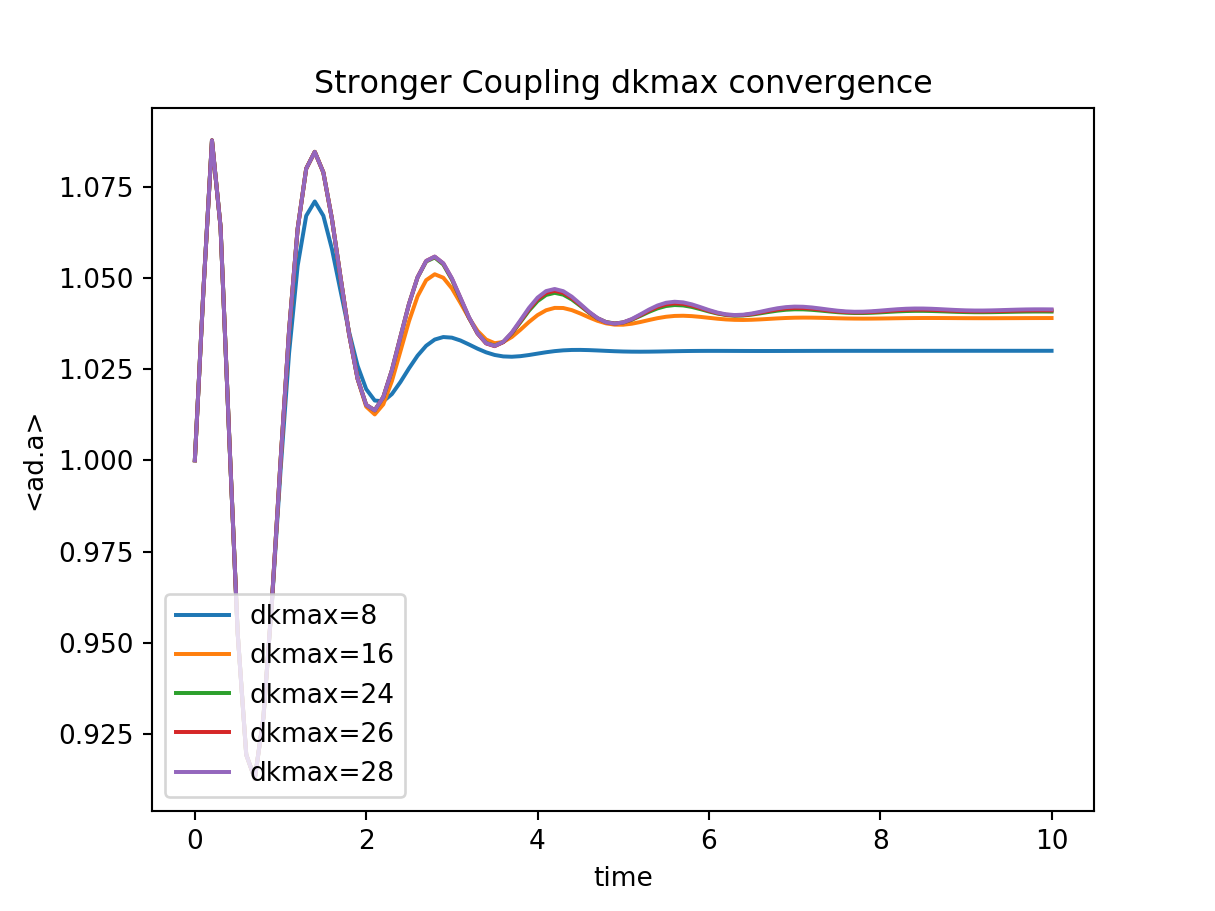

In [14]:
plt.figure(5)
for cc in [10]:
    for kk in [8,16,24,26,28]:
        for qq in [60]:
            daataa = datload("ConvergenceTestDkmax_coup"+str(cc)+"_dkm"+str(kk)+"_dt"+str(0.1).replace(".","")+"_Prec"+str(qq)+".pickle")
            TIME = [y[0] for y in daataa]
            steps = len(TIME)
            Occu = np.zeros([steps])
            for ii in range(steps):
                Occu[ii] = np.trace(np.dot(daataa[ii][1].reshape(DIM,DIM),Pocc)).real
            plt.plot(TIME,Occu,label='dkmax='+str(kk))
plt.ylabel('<ad.a>')
plt.xlabel('time')
plt.title('Stronger Coupling dkmax convergence') 
plt.legend(loc='lower left')
plt.show()

From this computation we decide that a dkmax of 24 is sufficient for this coupling strength! Nex we try lowering the precision

In [15]:
precisRange = [30, 40,45, 50, 60]
for cc in [10]:
    for kk in [26]:
        for qq in precisRange:
            def etaTest(t):
                #Double integral over the correlation function <B(t-s)B(s)>.
                #The spectral density is A*w^s*e^(-w/wc) with additional 
                #possibility of spatial seperation between two systems (mu-parameter)
                #(time, Temperature, s, wc, mu, A)
                return ln.eta_all(t,0,1,4,0,0.04*cc)

            dkmax=kk
            Precision = qq

            delt=0.1
            TimeSteps=80
            name="ConvergenceTestPrecStrong_coup"+str(cc)+"_dkm"+str(dkmax)+"_dt"+str(delt).replace(".","")+"_Prec"+str(qq)+".pickle"
            daa=tempo(eigs,etaTest,rhoi,H0,delt,TimeSteps,dkmax,Precision,datf=name,savemps=4)

data already collected up to ntot
data already collected up to ntot
data already collected up to ntot
data already collected up to ntot
data already collected up to ntot


<IPython.core.display.Javascript object>


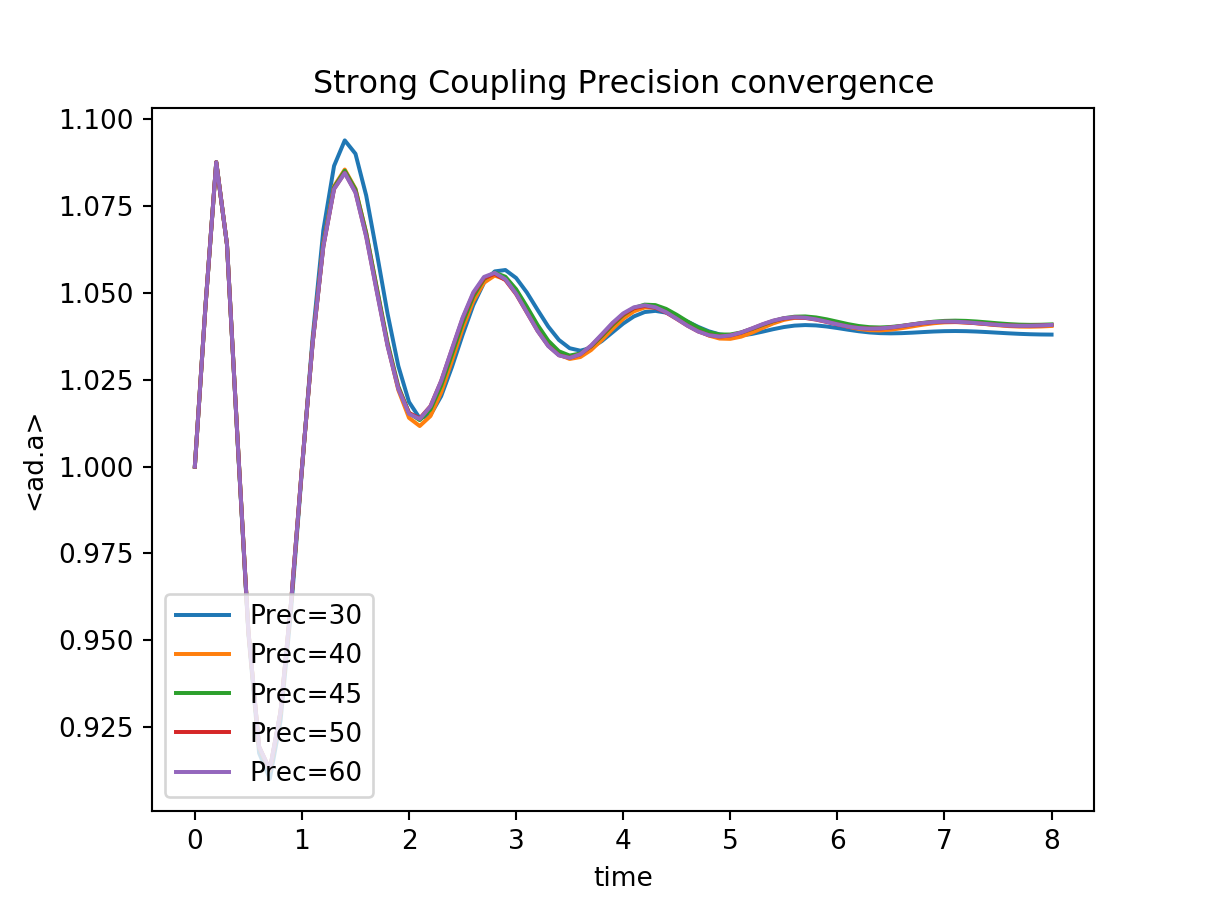

In [16]:
plt.figure(6)
for cc in [10]:
    for kk in [26]:
        for qq in [30,40,45,50,60]:
            daataa = datload("ConvergenceTestPrecStrong_coup"+str(cc)+"_dkm"+str(kk)+"_dt"+str(0.1).replace(".","")+"_Prec"+str(qq)+".pickle")
            TIME = [y[0] for y in daataa]
            steps = len(TIME)
            Occu = np.zeros([steps])
            for ii in range(steps):
                Occu[ii] = np.trace(np.dot(daataa[ii][1].reshape(DIM,DIM),Pocc)).real
            plt.plot(TIME,Occu,label='Prec='+str(qq))
plt.ylabel('<ad.a>')
plt.xlabel('time')
plt.title('Strong Coupling Precision convergence') 
plt.legend(loc='lower left')
plt.show()

This shows us that a precision of 45 is bordering being to small. So optimally one would use a precision of 50 for the strong coupling case.

Next step is to compare the two results.

<IPython.core.display.Javascript object>


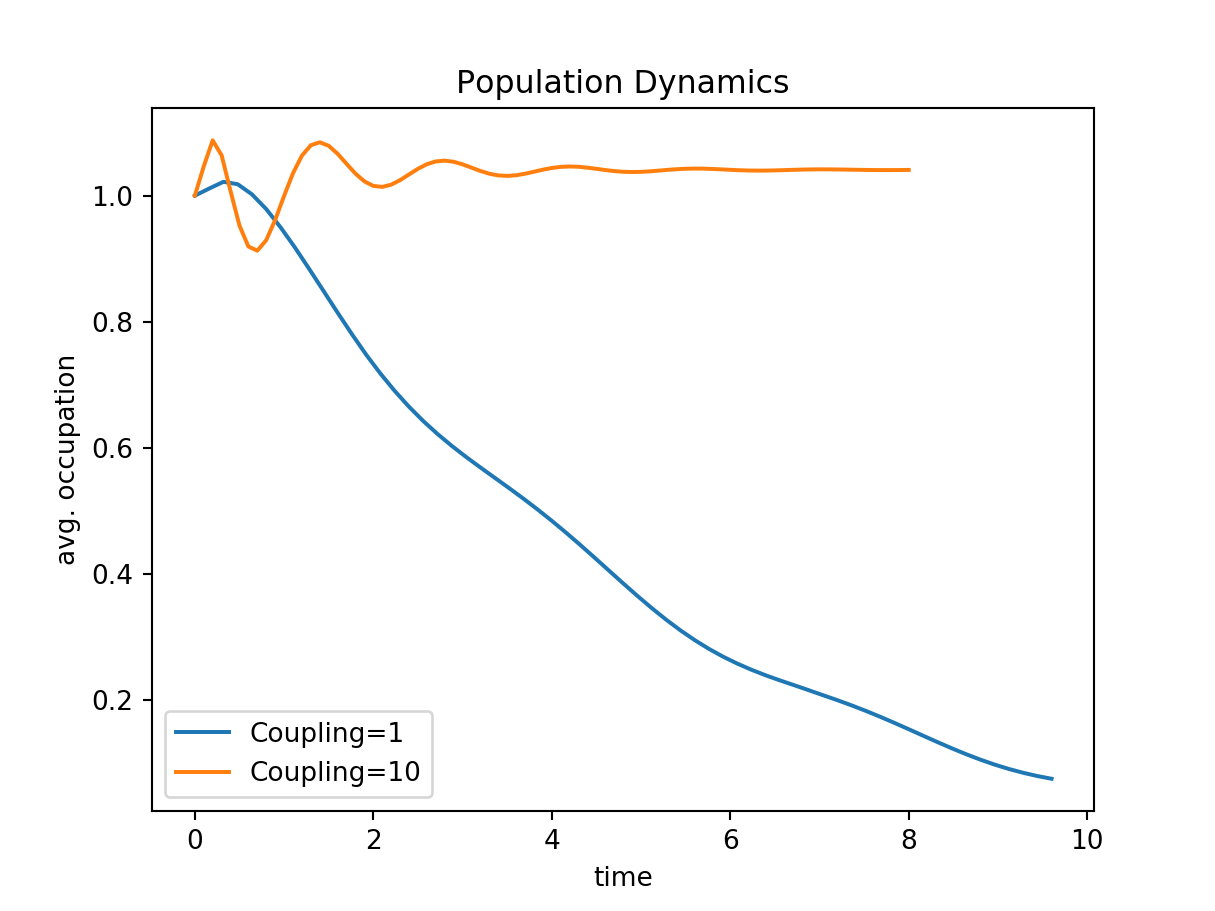

In [28]:
plt.figure(7)
for cc in [1, 10]:
    if cc==1:
        dkmax = 10
        prec = 30
        dt = 0.16
        daataa = datload("ConvergenceTestPrec_coup"+str(cc)+"_dkm"+str(dkmax)+"_dt"+str(dt).replace(".","")+"_Prec"+str(prec)+".pickle")
    elif cc==10:
        dkmax = 26
        prec = 50
        dt=0.1
        daataa = datload("ConvergenceTestPrecStrong_coup"+str(cc)+"_dkm"+str(dkmax)+"_dt"+str(dt).replace(".","")+"_Prec"+str(prec)+".pickle")
    TIME = [y[0] for y in daataa]
    steps = len(TIME)
    Occu = np.zeros([steps])
    for ii in range(steps):
        Occu[ii] = np.trace(np.dot(daataa[ii][1].reshape(DIM,DIM),Pocc)).real
    plt.plot(TIME,Occu,label='Coupling='+str(cc))
plt.ylabel('avg. occupation')
plt.xlabel('time')
plt.title('Population Dynamics') 
plt.legend(loc='lower left')
plt.figure(7).savefig('weakStrongDyn.png')

In [23]:
plt.savefig('weakStrongDyn.png')

Here it is seen that due the environment-system interaction is not particle conserving strong coupling results in a stationary state with a finite occupation in the system. To support this interpretation further we start the system without any inital excitations. The occupation should then increase until a similar value is reached.

In [18]:
for cc in [10]:
    for kk in [26]:
        for qq in [40]:
            def etaTest(t):
                #Double integral over the correlation function <B(t-s)B(s)>.
                #The spectral density is A*w^s*e^(-w/wc) with additional 
                #possibility of spatial seperation between two systems (mu-parameter)
                #(time, Temperature, s, wc, mu, A)
                return ln.eta_all(t,0,1,4,0,0.04*cc)

            dkmax=kk
            Precision = qq

            delt=0.1
            TimeSteps=80
            name="Strong_initVacuum_coup"+str(cc)+"_dkm"+str(dkmax)+"_dt"+str(delt).replace(".","")+"_Prec"+str(qq)+".pickle"
            daa=tempo(eigs,etaTest,rhoi0,H0,delt,TimeSteps,dkmax,Precision,datf=name,savemps=4)

data already collected up to ntot


<IPython.core.display.Javascript object>


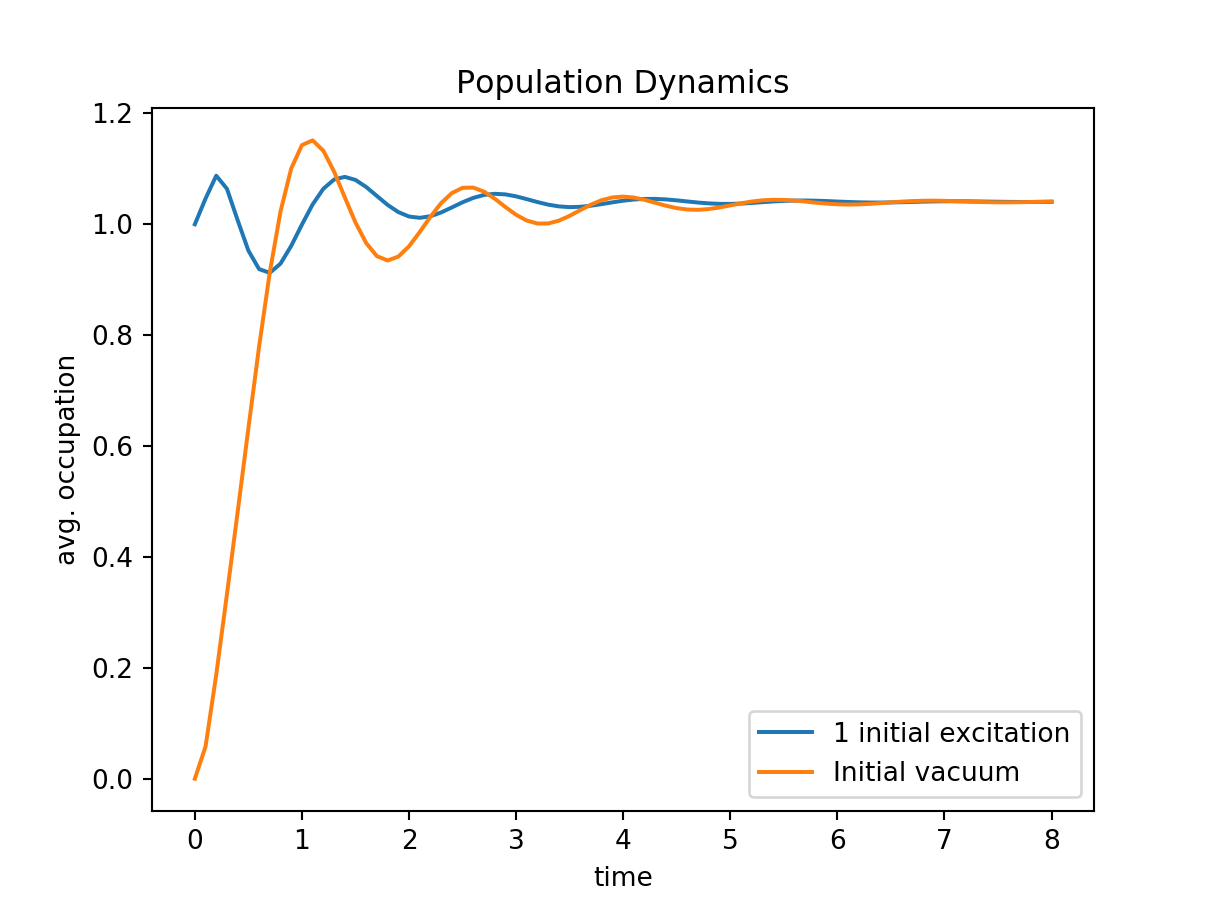

In [29]:
plt.figure(8)
cc=10
dkmax = 26
prec = 40
dt=0.1
daataa1 = datload("ConvergenceTestPrecStrong_coup"+str(cc)+"_dkm"+str(dkmax)+"_dt"+str(dt).replace(".","")+"_Prec"+str(prec)+".pickle")
daataa2 = datload("Strong_initVacuum_coup"+str(cc)+"_dkm"+str(dkmax)+"_dt"+str(dt).replace(".","")+"_Prec"+str(prec)+".pickle")
TIME = [y[0] for y in daataa2]
steps = len(TIME)
Occu1 = np.zeros([steps])
Occu2 = np.zeros([steps])
for ii in range(steps):
    Occu1[ii] = np.trace(np.dot(daataa1[ii][1].reshape(DIM,DIM),Pocc)).real
    Occu2[ii] = np.trace(np.dot(daataa2[ii][1].reshape(DIM,DIM),Pocc)).real
plt.plot(TIME,Occu1,label='1 initial excitation')
plt.plot(TIME,Occu2,label='Initial vacuum')
plt.ylabel('avg. occupation')
plt.xlabel('time')
plt.title('Population Dynamics') 
plt.legend(loc='lower right')
plt.figure(8).savefig('Vac1exc.png')

This agrees perfectly with our intial interpretation.

Now we want to investigate numerically how TEMPO scales with the dimensionality of the truncated boson system. For this we will consider the weak coupling case. 

In [ ]:
i=-1
for d in [3,4,5,6]:
    i += 1
    print(i)

In [ ]:
RunTime =np.zeros([5])
i = -1
for D in [3,4,5,6,7]:
    i += 1
    DIM = D
    ad= np.array(create(DIM).full())
    a=ad.transpose()
    #interaction operator
    si = ad+a
    Si = BasisCh(si,si)
    eigs = np.real(Si.diagonal())

    #system energy operator
    omega = 1
    h0 = omega*np.dot(ad,a)
    H0 = BasisCh(h0,si)

    #Initial density matrix
    Rhoi=np.zeros([DIM,DIM])
    Rhoi[1][1]=1
    rhoi = BasisCh(Rhoi,si)

    #occupation operator
    pocc = np.dot(ad,a)
    Pocc = BasisCh(pocc,si)
    
    for cc in [1]:
        for kk in [10]:
            for qq in [40]:
                def etaTest(t):
                    #Double integral over the correlation function <B(t-s)B(s)>.
                    #The spectral density is A*w^s*e^(-w/wc) with additional 
                    #possibility of spatial seperation between two systems (mu-parameter)
                    #(time, Temperature, s, wc, mu, A)
                    return ln.eta_all(t,0,1,4,0,0.04*cc)

                dkmax=kk
                Precision = qq

                delt=0.16
                TimeSteps=60
                name="ConvergTestDim_coup"+str(cc)+"_dkm"+str(dkmax)+"_dt"+str(delt).replace(".","")+"_Prec"+str(qq)+"_Dim"+str(DIM)+".pickle"
                t0 = time.time()
                daa=tempo(eigs,etaTest,rhoi,H0,delt,TimeSteps,dkmax,Precision,datf=name,savemps=4)
                RunTime[i] = time.time()-t0